# Imports

In [1]:
from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
import requests
import torch
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102
from torchvision.models import resnet18
from torchvision.transforms.v2 import Compose, RandomResizedCrop, Normalize, RandomHorizontalFlip, RandomVerticalFlip, \
    PILToTensor, Resize, CenterCrop
from tqdm.notebook import tqdm

from models.FlowersResnetWrapper import FlowersResnetWrapper
%matplotlib inline

train = False

# Preparing the dataset

The dataset used is Flowers102 from oxford. Let's initialize mean and std that I'm going to use to normalize the images. Since I'll use ResNet the mean and std will the ones from ImageNet dataset

In [2]:
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

I will also initialize the transformations used to augment the data, notice that the ones used in training and the one used in test are slightly different.

In [3]:
train_transforms = Compose([PILToTensor(),
                            lambda x: x/255,
                            Normalize(mean, std),
                            RandomResizedCrop((256, 256), antialias=True),
                            RandomHorizontalFlip(0.5),
                            RandomVerticalFlip(0.5)])

test_transforms = Compose([PILToTensor(),
                           lambda x: x/255,
                           Normalize(mean, std),
                           Resize((512, 512)),
                           CenterCrop((256, 256))])

Let's start the download

In [4]:
if not Path('./data').exists():
    Flowers102('data', download=True)
fl_train = Flowers102('./data', split='train', transform=train_transforms)
fl_val = Flowers102('./data', split='val', transform=train_transforms)
fl_test = Flowers102('./data', split='test', transform=test_transforms)

Let's visualize some images from the dataset

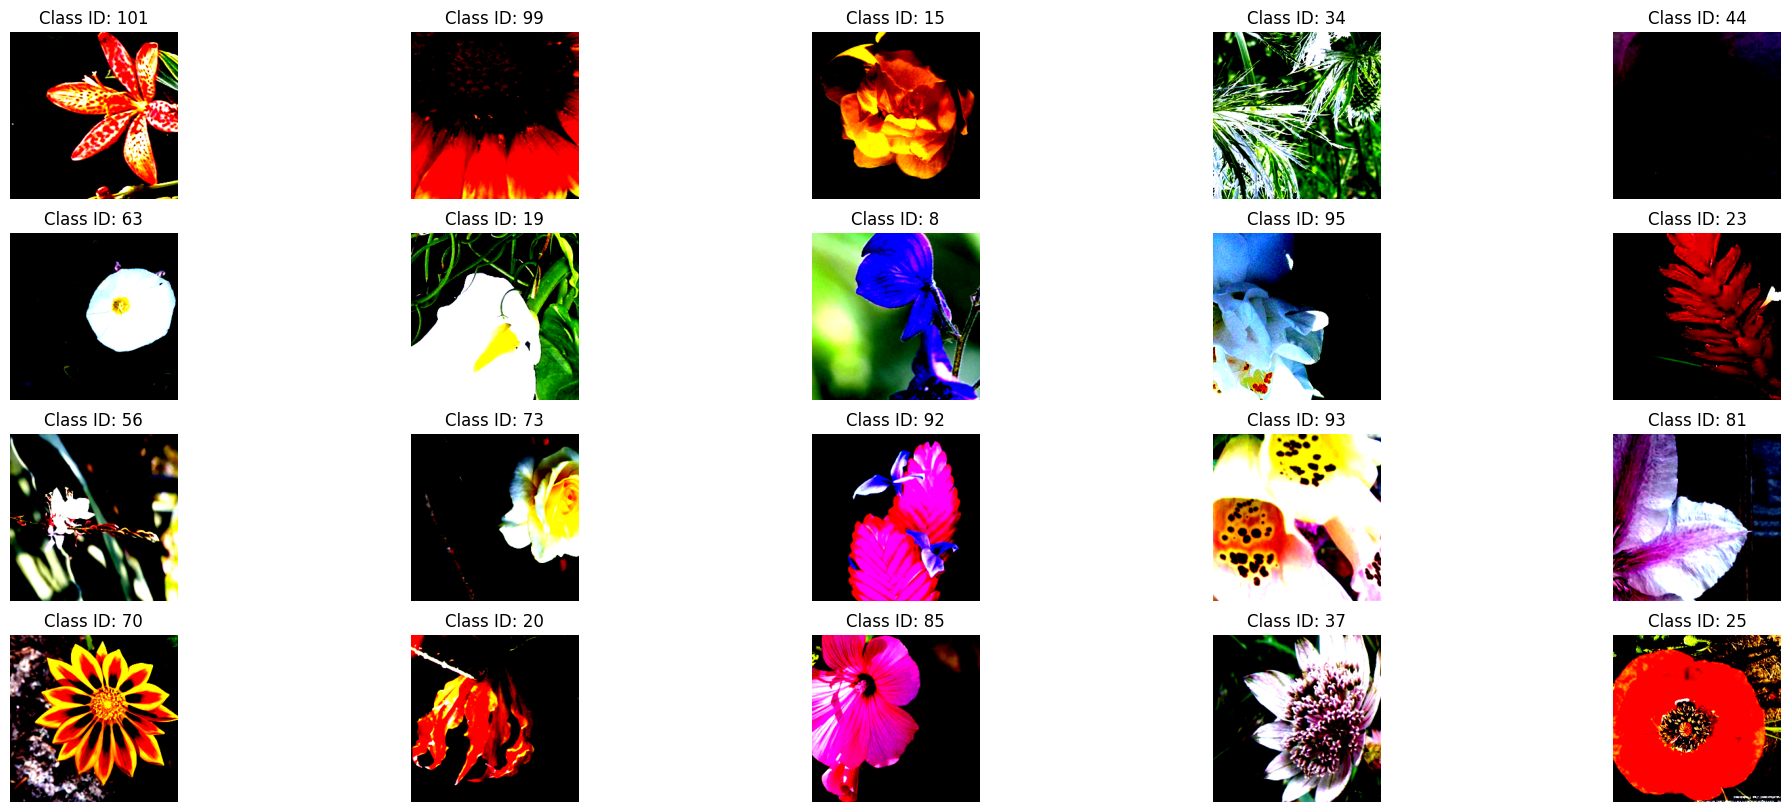

In [5]:
def show_imgs(dset: torch.utils.data.Dataset, n: int = 10):
    import warnings
    fig, ax = plt.subplots(nrows=(n-1)//5+1, ncols=5, figsize=(25, 10))
    img_ids = torch.randperm(len(dset))[:n]
    with warnings.catch_warnings():
        for i, img_id in enumerate(img_ids):
            img, label = dset[img_id]
            img = torch.permute(img, (1, 2, 0)).clip(0, 1)
            ax[i//5][i%5].set_title(f'Class ID: {label}')
            ax[i//5][i%5].imshow(img)
            ax[i//5][i%5].axis('off')
show_imgs(fl_train, n=20)

Notice that these images have been standardized ad cropped, this is why they look unnatural.

Let's now check the class distribution in the training set

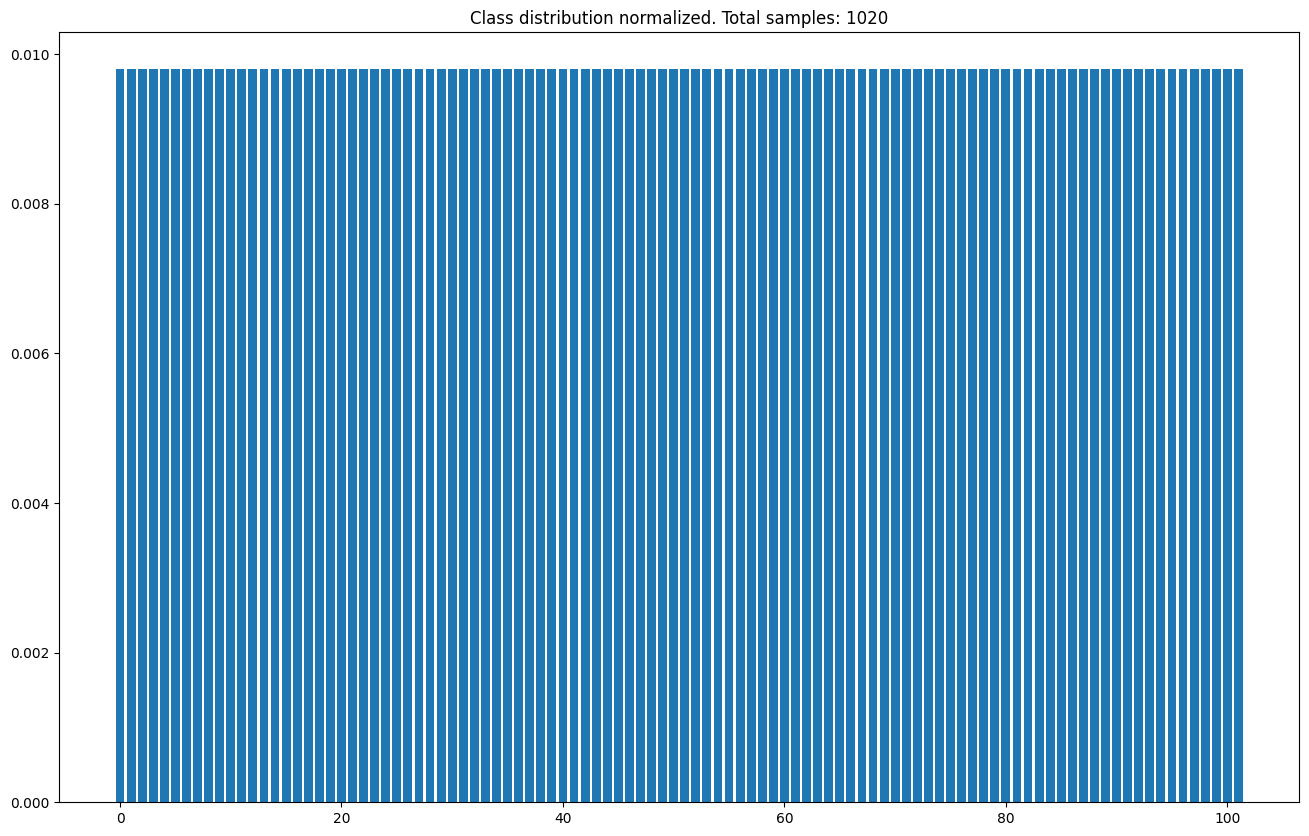

In [6]:
def check_dist(dset: torch.utils.data.Dataset):
    plt.figure(figsize=(16, 10))
    dist = torch.zeros(102)
    for _, label in dset:
        dist[label] += 1
    dist /= len(dset)
    plt.title(f'Class distribution normalized. Total samples: {len(dset)}')
    plt.bar(range(102), dist)
    
check_dist(fl_train)

The class distribution is uniform. While this is not bad news, we have 1020 training samples and 102 classes, this means that we only have 10 images per class!

It is unfeasible to train a neural network from scratch under this condition, therefore transfer learning seems the way to go. Let's initialize the dataloaders

In [7]:
train_dl = DataLoader(fl_train, batch_size=64, shuffle=True)
val_dl = DataLoader(fl_val, batch_size=64, shuffle=True)
test_dl = DataLoader(fl_test, batch_size=64, shuffle=True)

# Transfer learning with ResNet

Let's load ResNet with ImageNet weights and let's swap its classifier with a custom one

In [8]:
resnet = resnet18(weights='IMAGENET1K_V1')
for param in resnet.parameters():
    resnet.requires_grad = False
dims = resnet.fc.in_features
resnet.fc = torch.nn.Linear(dims, 102)

Let's print the model structure as a sanity check

In [9]:
import torchinfo

torchinfo.summary(resnet, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 102]                  --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

Let's write the loop functions to train it. The loss used wll be categorical crossentropy, while the main metric will be accuracy

In [10]:
from torch.nn import Module
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchmetrics import Accuracy

def train_loop(model: Module, dataloader: DataLoader, epoch_id: int, opti: torch.optim.Optimizer, scheduler: torch.optim.lr_scheduler) -> dict:
    model.train()
    ce_loss = CrossEntropyLoss(label_smoothing=0.1).to(device='cuda')
    acc = Accuracy(task='multiclass', num_classes=102).to(device='cuda')
    running_loss = 0
    running_acc = 0
    with tqdm(enumerate(dataloader), total=len(dataloader), desc=f'Epoch {epoch_id}', unit='batch', postfix=f'') as pbar:
        for batch_id, batch in pbar:
            opti.zero_grad()
            te, gt = batch
            te = te.to(device='cuda')
            gt = gt.to(device='cuda')
            model_out = model(te)
            loss = ce_loss(model_out, gt)
            running_loss += loss.item()
            loss.backward()
            accuracy = acc(torch.argmax(model_out, dim=-1), gt)
            running_acc += accuracy.item()
            opti.step()
            scheduler.step()
            pbar.set_postfix_str(f'loss={round(running_loss/(batch_id+1), 2)}, accuracy={round(running_acc/(batch_id+1), 2)}')
    return {'loss': running_loss/len(dataloader), 'accuracy': running_acc/len(dataloader)}

def val_loop(model: Module, dataloader: DataLoader) -> dict:
    model.eval()
    ce_loss = CrossEntropyLoss(label_smoothing=0.1).to(device='cuda')
    acc = Accuracy(task='multiclass', num_classes=102).to(device='cuda')
    running_loss = 0
    running_acc = 0
    with torch.no_grad():
        with tqdm(enumerate(dataloader), total=len(dataloader), unit='batch', postfix=f'') as pbar:
            for batch_id, batch in pbar:
                te, gt = batch
                te = te.to(device='cuda')
                gt = gt.to(device='cuda')
                model_out = model(te)
                loss = ce_loss(model_out, gt)
                running_loss += loss.item()
                accuracy = acc(torch.argmax(model_out, dim=-1), gt)
                running_acc += accuracy.item()
                pbar.set_postfix_str(f'loss={round(running_loss/(batch_id+1), 2)}, accuracy={round(running_acc/(batch_id+1), 2)}')
    return {'loss': running_loss/len(dataloader), 'accuracy': running_acc/len(dataloader)}


In [11]:
def loop(model, epochs, train_dataloader, val_dataloader, optimizer, scheduler):
    history = []
    history_val = []
    for i, epochs in enumerate(range(epochs)):
        h = train_loop(model, train_dataloader, i+1, optimizer, scheduler)
        vh = val_loop(model, val_dataloader)
        history.append(h)
        history_val.append(vh)
    return history, history_val

Let's train for 100 epochs

In [12]:
if train:
    adam = Adam(resnet.parameters(), lr=1e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(adam, 100, eta_min=0)
    resnet.to(device='cuda')
    res = loop(resnet, 100, train_dl, val_dl, adam, sched)

In [13]:
if train:
    train_loss_history = [v['loss'] for v in res[0]]
    train_acc_history = [v['accuracy'] for v in res[0]]
    val_loss_history = [v['loss'] for v in res[1]]
    val_acc_history = [v['accuracy'] for v in res[1]]
    fig, ax = plt.subplots(figsize=(20,10))
    color = 'tab:red'
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss scale', color=color)
    ax.plot(range(100), train_loss_history, label='Train loss')
    ax.plot(range(100), train_loss_history, label='Validation loss')
    ax.tick_params(axis='y', labelcolor=color)
    ax.legend(loc=0)
    
    ax2 = ax.twinx()  # instantiate a second Axes that shares the same x-axis
    
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(range(100), train_acc_history, color='tab:green', label='Train accuracy')
    ax2.plot(range(100), val_acc_history, color='tab:red', label='Validation accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    plt.legend()
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

There seems to be a low amount of overfitting when the training accuracy breaks 0.9, but aside from that everything seems to be ok.

Let's save the pytorch checkpoint

In [14]:
if train:
    torch.save(resnet.state_dict(), './models/checkpoints/resnet.pth')

# Evaluation

Let's start by loding the wrapper with the checkpoint

In [15]:
resnet = FlowersResnetWrapper('./models/checkpoints/resnet.pth')

Let's compute the predictions on the full test set

In [16]:
full_gt = []
full_pred = []
for batch, gt in test_dl:
    with torch.no_grad():
        model_pred = resnet(batch)
        full_gt += gt.tolist()
        full_pred += model_pred['class_ids'].tolist()


Let's evaluate the results

Accuracy on the test set: 0.8720117211341858


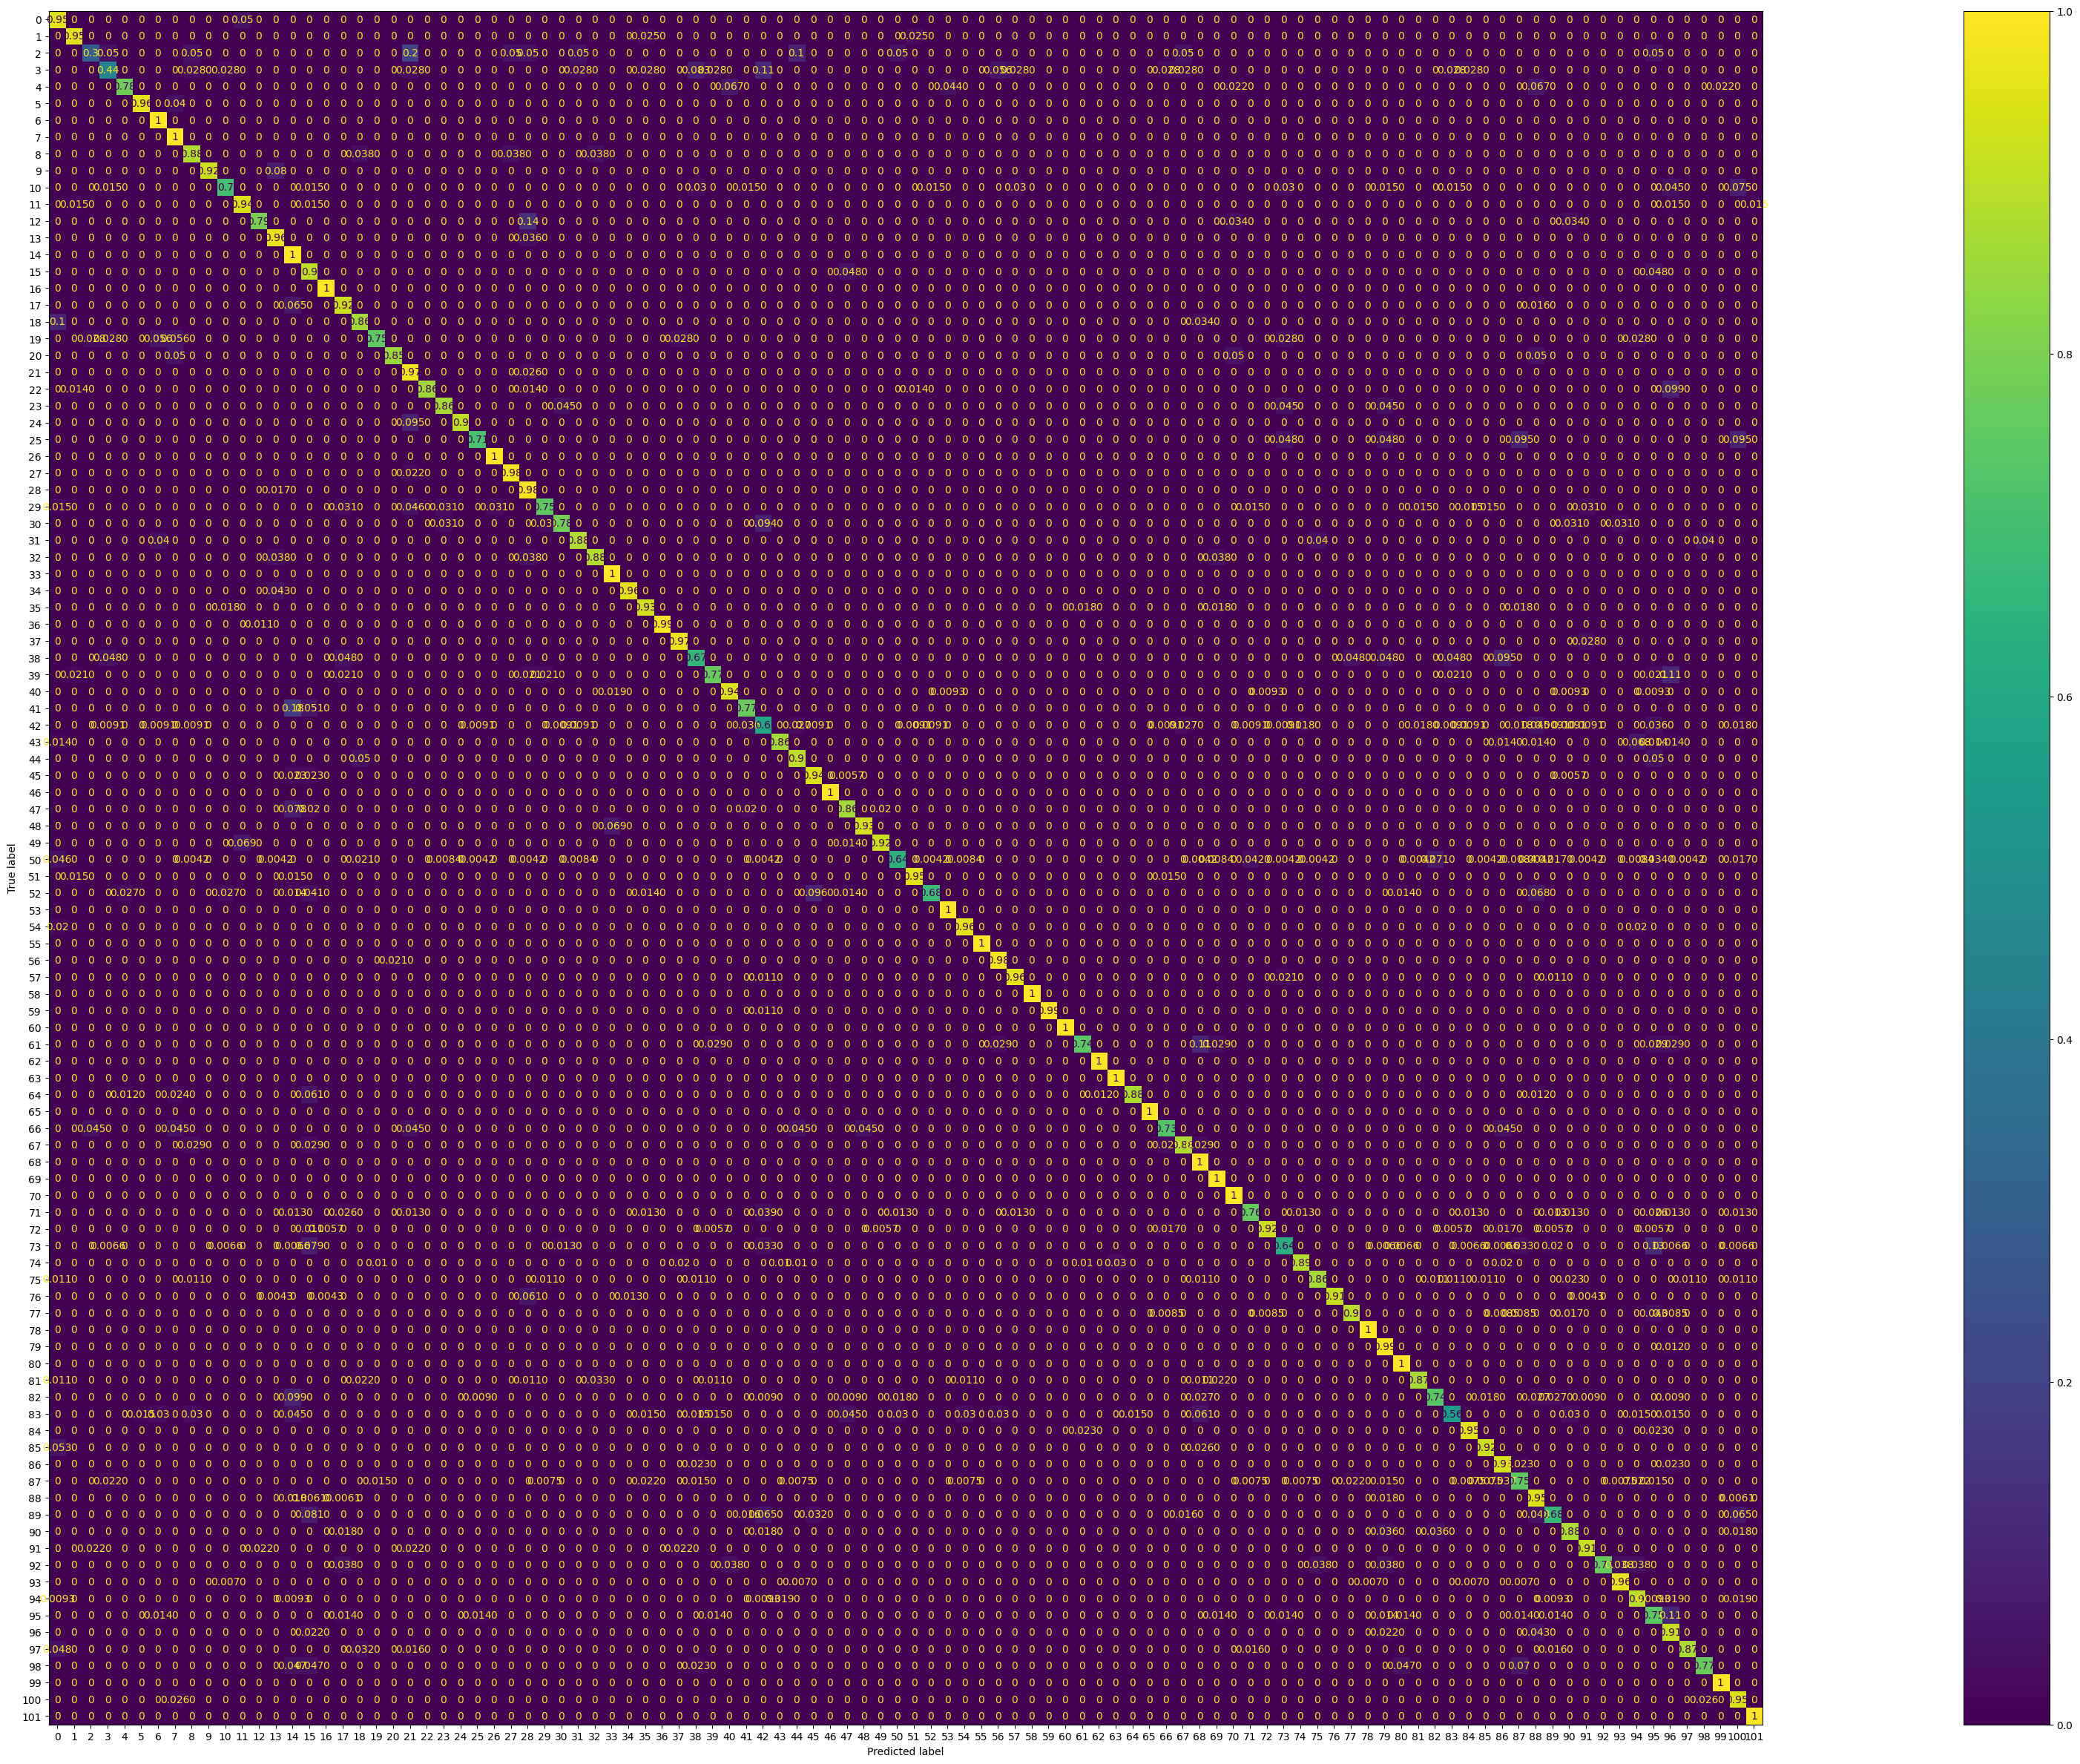

In [17]:
print(f"Accuracy on the test set: {Accuracy(task='multiclass', num_classes=102)(torch.Tensor(full_pred), torch.Tensor(full_gt))}")
cm = ConfusionMatrixDisplay(confusion_matrix(full_gt, full_pred, normalize='true'));
fig, ax = plt.subplots(figsize=(70, 30))
cm.plot(ax=ax);

The model achieves 87% accuracy on unseen data, and from the confusion matrix the performance seems fairly stable.

Let's try with an image from Google of a desert rose

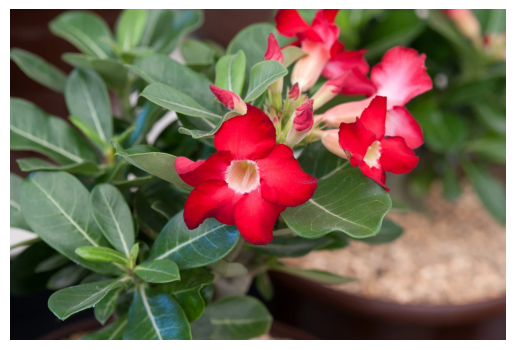

In [18]:
url = 'https://images.immediate.co.uk/production/volatile/sites/10/2018/08/802deda2-f2d0-44e5-b1ed-9724eb6de288-1534575.jpg?quality=90&webp=true&resize=1200,800'
response = requests.get(url)
rose_img = Image.open(BytesIO(response.content))
plt.axis('off')
plt.imshow(rose_img);

Let's preprocess it with the preprocess() function of the wrapper

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1151404..2.44461].


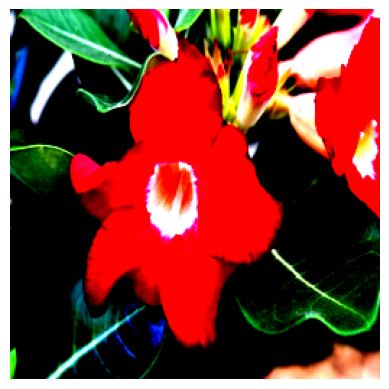

In [19]:
preprocessed = resnet.preprocess(rose_img)
plt.axis('off')
plt.imshow(torch.permute(preprocessed[0, :, :, :], (1, 2, 0)));

Let's check the model prediction

In [20]:
print(f'Predicted class: {resnet(preprocessed)["class_names"]}')

Predicted class: ['desert-rose']
